In [1]:
import rpy2
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

import numpy as np
import pandas as pd

%config IPCompleter.greedy=True

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

In [2]:
import ray
ray.init()

RayContext(dashboard_url='', python_version='3.8.10', ray_version='1.12.1', ray_commit='4863e33856b54ccf8add5cbe75e41558850a1b75', address_info={'node_ip_address': '18.26.5.6', 'raylet_ip_address': '18.26.5.6', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-05-31_15-19-14_397829_573081/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-05-31_15-19-14_397829_573081/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-05-31_15-19-14_397829_573081', 'metrics_export_port': 64184, 'gcs_address': '18.26.5.6:37135', 'address': '18.26.5.6:37135', 'node_id': 'bf2224e90c6b52c274157dc4306bcaa0e4ed04527fd0fc4cab6ea31b'})

In [3]:
rootdir = "/home/akshayn/burrito"
outdirs = ["datapath-bench-data"]
datapaths = ['shenango', 'dpdk', 'dpdkinline']
loads = [10000, 40000, 80000, 100000, 160000, 200000]
work = ['imm', 'cpu:1000', 'mem:1000', 'cpu:1000~500', 'mem:1000~500', 'cpu:50~50:1500~1000', 'mem:50~50:1500~1000']
num_clients = [1, 4]
req_paddings = [0, 1024]
iters = 3

In [4]:
clients = ['10.1.1.6', '10.1.1.5']

@ray.remote
def read_exp(outdir, dp, load, wt, nc, rp, iters):
    df_iters = []
    
    for i in range(iters):
        for cl in clients:
            fn = f"{rootdir}/{outdir}/{dp}-load={load}-work={wt}-num_clients={nc}-padding={rp}-{i}-dbench_client-{cl}.data"
            try:
                df_iter = pd.read_csv(fn, sep=" ")
                df_iter["iter"] = i
                df_iters.append(df_iter)
                break
            except Exception as e:
                #print(e)
                pass
    if len(df_iters) == 0:
        print(f'no files for configuration: {(dp, load, wt, nc, rp)}')
        return pd.DataFrame()
        
    df = pd.concat(df_iters)
    try:
        df = df.groupby(["Offered_load_rps"]).quantile([0.05, 0.25, 0.5, 0.75, 0.95])
        df = df.unstack()
        df.columns = [f"{s}_{t}" for s,t in df.columns.values]
        df.columns = df.columns.to_flat_index()
        df = df.reset_index()

        df["Outdir"] = outdir
        df["Datapath"] = dp
        df["Load"] = load
        df["WorkType"] = wt
        df["NumClients"] = nc
        df["Padding"] = rp
        return df
    except Exception as e:
        print(e)
        return pd.DataFrame()

exp_dfs = []
for outdir in outdirs:
    for dp in datapaths:
        for l in loads:
            for w in work:
                for nc in num_clients:
                    for rp in req_paddings:
                        exp_df = read_exp.remote(outdir, dp, l, w, nc, rp, iters)
                        exp_dfs.append(exp_df)

                    
exps = pd.concat(ray.get(exp_dfs))
exps

,Offered_load_rps,NumOps_0.05,NumOps_0.25,NumOps_0.5,NumOps_0.75,NumOps_0.95,Completion_ms_0.05,Completion_ms_0.25,Completion_ms_0.5,Completion_ms_0.75,...,iter_0.25,iter_0.5,iter_0.75,iter_0.95,Outdir,Datapath,Load,WorkType,NumClients,Padding
0,10000,300000.0,300000.0,300000.0,300000.0,300000.0,30561.0,30561.0,30562.0,30562.0,...,0.0,1.0,2.0,2.0,datapath-bench-data,shenango,10000,imm,1,0
0,10000,300000.0,300000.0,300000.0,300000.0,300000.0,30562.0,30562.0,30562.0,30562.0,...,0.0,1.0,2.0,2.0,datapath-bench-data,shenango,10000,imm,1,1024
0,10000,299997.0,299997.0,299998.0,299998.0,299998.0,30556.0,30556.0,30556.0,30557.0,...,0.0,1.0,2.0,2.0,datapath-bench-data,shenango,10000,imm,4,0
0,10000,299995.0,299995.0,299996.0,299996.0,299996.0,30556.0,30556.0,30557.0,30557.0,...,0.0,1.0,2.0,2.0,datapath-bench-data,shenango,10000,imm,4,1024
0,10000,300000.0,300000.0,300000.0,300000.0,300000.0,30563.0,30563.0,30563.0,30574.0,...,0.0,1.0,2.0,2.0,datapath-bench-data,shenango,10000,cpu:1000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,200000,5998454.0,5998454.0,5998596.0,5998655.0,5998655.0,30126.0,30126.0,30129.0,30132.0,...,0.0,1.0,2.0,2.0,datapath-bench-data,dpdkinline,200000,cpu:50~50:1500~1000,4,1024
0,200000,4593686.0,4593686.0,4594375.0,5081526.0,5081526.0,30000.0,30000.0,30000.0,30000.0,...,0.0,1.0,2.0,2.0,datapath-bench-data,dpdkinline,200000,mem:50~50:1500~1000,1,0
0,200000,4595648.0,4595648.0,4599643.0,5082274.0,5082274.0,30000.0,30000.0,30000.0,30000.0,...,0.0,1.0,2.0,2.0,datapath-bench-data,dpdkinline,200000,mem:50~50:1500~1000,1,1024
0,200000,5998400.0,5998400.0,5998594.0,5998701.0,5998701.0,30126.0,30126.0,30132.0,30132.0,...,0.0,1.0,2.0,2.0,datapath-bench-data,dpdkinline,200000,mem:50~50:1500~1000,4,0


In [5]:
exps.columns

Index(['Offered_load_rps', 'NumOps_0.05', 'NumOps_0.25', 'NumOps_0.5',
       'NumOps_0.75', 'NumOps_0.95', 'Completion_ms_0.05',
       'Completion_ms_0.25', 'Completion_ms_0.5', 'Completion_ms_0.75',
       'Completion_ms_0.95', 'Latency_us_0.05', 'Latency_us_0.25',
       'Latency_us_0.5', 'Latency_us_0.75', 'Latency_us_0.95',
       'Server_us_0.05', 'Server_us_0.25', 'Server_us_0.5', 'Server_us_0.75',
       'Server_us_0.95', 'iter_0.05', 'iter_0.25', 'iter_0.5', 'iter_0.75',
       'iter_0.95', 'Outdir', 'Datapath', 'Load', 'WorkType', 'NumClients',
       'Padding'],
      dtype='object')

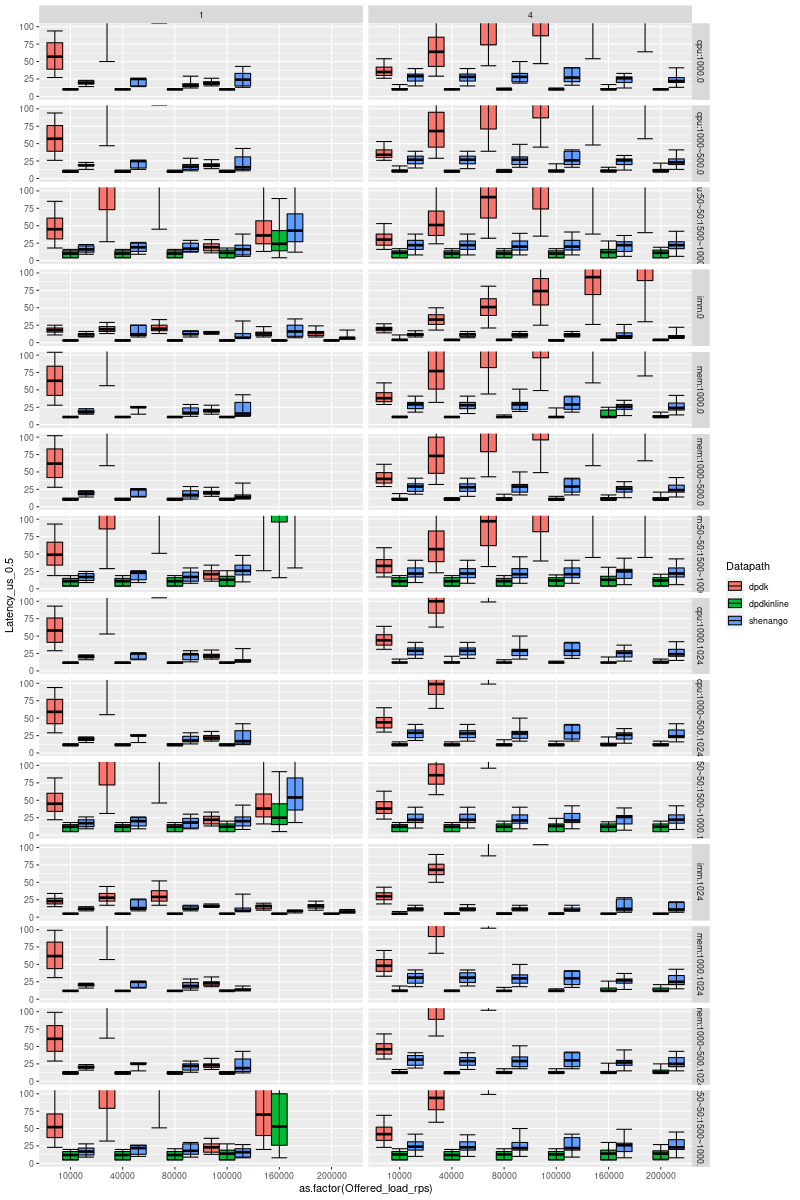

In [6]:
%%R -i exps -w 800 -h 1200

library(ggplot2)

ggplot(exps, aes(x=as.factor(Offered_load_rps), fill=Datapath)) +
  geom_crossbar(aes(ymin=Latency_us_0.25, y=Latency_us_0.5, ymax = Latency_us_0.75), position="dodge") +
  geom_errorbar(aes(ymin=Latency_us_0.05, ymax=Latency_us_0.95), position="dodge") +
  facet_grid(interaction(WorkType, Padding) ~ interaction(NumClients), scale="free_y") +
    coord_cartesian(ylim=c(0,100))

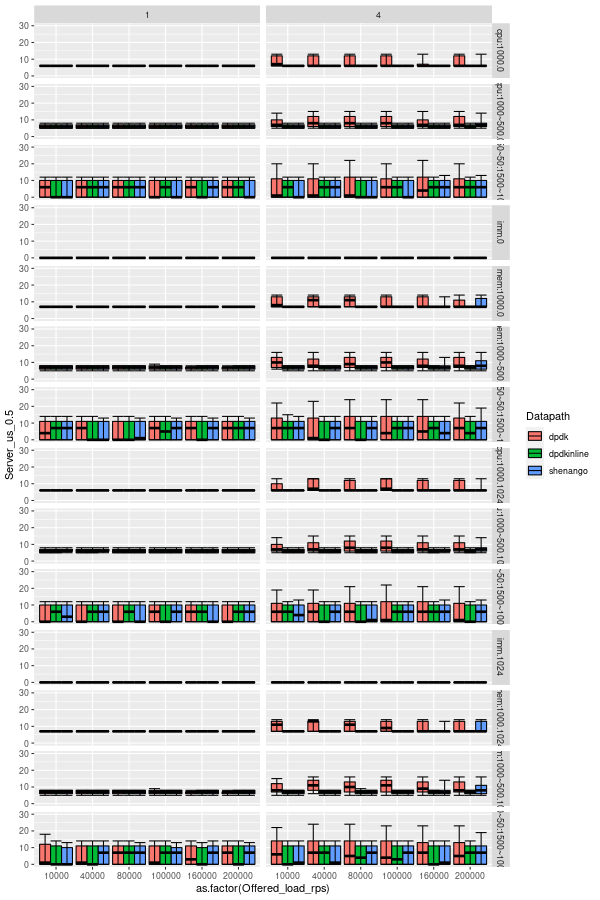

In [7]:
%%R -i exps -w 600 -h 900

library(ggplot2)

ggplot(exps, aes(x=as.factor(Offered_load_rps), fill=Datapath)) +
  geom_crossbar(aes(ymin=Server_us_0.25, y=Server_us_0.5, ymax = Server_us_0.75), position="dodge") +
  geom_errorbar(aes(ymin=Server_us_0.05, ymax=Server_us_0.95), position="dodge") +
  facet_grid(interaction(WorkType, Padding) ~ interaction(NumClients), scale="free_y") +
    coord_cartesian(ylim=c(0,30))